### Introduction
I noticed that reddit being the expansive website that it is has subreddits for each of the Meyers Briggs personality types. I thought it would be interesting to see some of the differences between population data and the reddit data.

The goal of this notebook is to scrape and visualize the data I find. These will be pretty high level and should be taken as a light exercise in Exploritory Data Analysis (EDA) and practice in python. 

Ill be using [pandas](pandas.pydata.org/) to handle the data as it is the standard tool in python. 

[PRAW](http://praw.readthedocs.io/) will help me with parsing the reddit data. Redditmade scraping initially difficult, but I found [this](http://progur.com/2016/09/how-to-create-reddit-bot-using-praw4.html) to be the best way. I believe there are alternatives out there though.

Lastly, I hate how matplotlib looks, so I wanted to check out how functional the [best port of ggplot2](https://github.com/has2k1/plotnine) is for python.

In [32]:
import pandas as pd
import itertools
import praw
import json
import datetime as DT
from plotnine import *
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

# Import Bokeh modules for interactive plotting
import bokeh.charts
import bokeh.io
import bokeh.models
import bokeh.palettes
import bokeh.plotting

output_notebook()

Loading BokehJS ...

Although it would probably have been easier to copy and paste a list from the web or to write it out myself, I thought it would be interesting to check out what the almighty python standard library can do. [Itertools](https://docs.python.org/3/library/itertools.html) is pretty handy and `itertools.product` allowed me to generate each personality type from the `dichotomies` list.

In [23]:
# Create list of personality types
dichotomies = [('E', 'I'), ('N', 'S'), ('T', 'F'), ('P', 'J')]
personality_types_tuples = list(itertools.product(*dichotomies))
personality_types = [''.join(pt_tuple) for pt_tuple in personality_types_tuples]

[Pandas](pandas.pydata.org/) has a really cool ability to [parse an HTML table](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_html.html) just given the url. Even if the URL contains a lot more than just a table! In this case my url has a table showing the distribution of personality types in the general population.

In [24]:
# Get HTML Table
pt_dist_url = 'https://www.careerplanner.com/MB2/TypeInPopulation.cfm'
pt_dist_df = pd.read_html(pt_dist_url)
pt_dist_df = pt_dist_df[-1]

# Properly construct the DataFrame
pt_dist_df[2][0] = pt_dist_df[1][0]
del pt_dist_df[1]
pt_dist_df = pt_dist_df.iloc[1:]
pt_dist_df.columns = ['type', 'pop_freq']
pt_dist_df = pt_dist_df.set_index('type')

# Convert string percentage to numeric
pt_dist_df['pop_freq'] = pd.to_numeric(pt_dist_df['pop_freq'].str.strip('%'))/100

Here I setup [PRAW](http://praw.readthedocs.io/) which helps me parse reddit. I feed it the subreddits generated from the itertools line above and I put the data into a dataframe.

In [25]:
# Get authentication information
with open('authentication.json') as file:
    auth = json.load(file)

reddit = praw.Reddit(client_id=auth['client_id'], client_secret=auth['client_secret'],
                     password=auth['password'], user_agent=auth['user_agent'],
                     username=auth['username'])

# Create Reddit DataFrame
pt_sr_info_df_columns = ['display_name', 'created_utc', 'description', 'name', 'subscribers', 'gilded']
pt_sr_info_df = pd.DataFrame(columns=pt_sr_info_df_columns, index=personality_types)
pt_sr_info_df.index.name = 'ptypes'
for ptype in personality_types:
    sr_name = reddit.subreddit(ptype).name

    sr_info = next(reddit.info([sr_name]))
    sr_info_vars = vars(sr_info)
    ptype_row = []
    for col in pt_sr_info_df.columns[:-1]:
        ptype_row.append(sr_info_vars[col])

    gilded_count = sum(1 for i in reddit.subreddit(ptype).gilded())
    ptype_row.append(gilded_count)

    pt_sr_info_df.loc[ptype] = ptype_row
    

After generating a dataframe from the reddit data, I then merge the dataframes from the general population and generate some interesting features.

The main feature of interest is subscribers proportion. The way it works is I find the total number of subscribers and scale that proportionately to the percentage of each of personality types in the population.

Note: this isnt a perfect calculation, the issue is that the number of subscribers doesnt necessarily reflect the personality type on reddit. There could be people subscribed to personality types that arent their own, or multiple. 

In [26]:
# Concatenating the data
df = pd.concat([pt_sr_info_df, pt_dist_df], axis=1)

# Feature engineering
df['description_length'] = df.description.apply(len)
df['creation_date'] = pd.to_datetime(df.created_utc, unit='s')
df['subreddit_age'] = pd.Timestamp(DT.datetime.now()) - df.creation_date
df['subscribers_percentage'] = df['subscribers']/df['subscribers'].sum()
df['pt_percentage_differences'] = df['pop_freq'] - df['subscribers_percentage']
df['type'] = df.index
df['subscribers_expected'] = df['pop_freq'] * df['subscribers'].sum()

In [29]:
df.reset_index(inplace=True)
df

,level_0,index,display_name,created_utc,description,name,subscribers,gilded,pop_freq,description_length,creation_date,subreddit_age,subscribers_percentage,pt_percentage_differences,type,subscribers_expected
0,0,ENFJ,enfj,1.24852e+09,**Quote of the Week/Month (Whenever mod rememb...,t5_2r36p,3594,0,0.025,1751,2009-07-25 09:58:20,2962 days 12:03:10.482448,0.0210855,0.00391451,ENFJ,4261.225
1,1,ENFP,ENFP,1.25041e+09,">* [NT, Rationalists](http://www.reddit.com/r/...",t5_2r4yi,13258,37,0.081,2010,2009-08-16 06:43:57,2940 days 15:17:33.482448,0.0777828,0.0032172,ENFP,13806.369
2,2,ENTJ,entj,1.24852e+09,The Myers-Briggs Type Indicator (MBTI) is a te...,t5_2r36o,4805,5,0.018,1818,2009-07-25 09:57:16,2962 days 12:04:14.482448,0.0281903,-0.0101903,ENTJ,3068.082
3,3,ENTP,entp,1.22735e+09,##A subreddit for and about the Myers-Briggs t...,t5_2qoy3,11086,25,0.032,4289,2008-11-22 11:06:25,3207 days 10:55:05.482448,0.06504,-0.03304,ENTP,5454.368
4,4,ESFJ,ESFJ,1.33159e+09,">* [NT, Rationalists](http://www.reddit.com/r/...",t5_2tpru,873,0,0.123,658,2012-03-12 23:02:42,2000 days 22:58:48.482448,0.00512177,0.117878,ESFJ,20965.227
5,5,ESFP,ESFP,1.35041e+09,"##Description\n\nThe MBTI, short for Myers-Bri...",t5_2vb68,948,0,0.085,1346,2012-10-16 18:29:05,1783 days 03:32:25.482448,0.00556178,0.0794382,ESFP,14488.165
6,6,ESTJ,ESTJ,1.32919e+09,ESTJ,t5_2tk2p,893,0,0.087,4,2012-02-14 04:23:18,2028 days 17:38:12.482448,0.0052391,0.0817609,ESTJ,14829.063
7,7,ESTP,estp,1.33294e+09,"-----\n**ESTPs** are outgoing, straight-shooti...",t5_2tt3a,1078,0,0.043,925,2012-03-28 14:02:32,1985 days 07:58:58.482448,0.00632447,0.0366755,ESTP,7329.307
8,8,INFJ,infj,1.24863e+09,"######\n\n#**""The master has failed more times...",t5_2r39a,23073,68,0.015,3828,2009-07-26 18:20:53,2961 days 03:40:37.482448,0.135366,-0.120366,INFJ,2556.735
9,9,INFP,infp,1.22286e+09,">* [ NT, Rationalists ](http://www.reddit....",t5_2qn2o,26060,68,0.044,4064,2008-10-01 12:05:38,3259 days 09:55:52.482448,0.15289,-0.10889,INFP,7499.756


Now I have all the data I need, I can start making interesting plots!

In [39]:
# (ggplot(df.sort_values(['subscribers'])) +
#     geom_col(aes('type', 'subscribers', fill='type'), stat="identity") +
#     geom_point(aes('type', y='subscribers_expected')) +
#     guides(fill=False) +
#     ggtitle('Subreddit Subscribers by MBTI Personality Type')+
#     geom_line())

p = figure(title='Subreddit Subscribers by MBTI Personality Type')
p = bokeh.charts.Line(df, x='index', y='subscribers_expected')
p.rect(width=.4, height='subscribers', x='index', y='subscribers')
show(p)

TypeError: unsupported operand type(s) for -: 'str' and 'str'

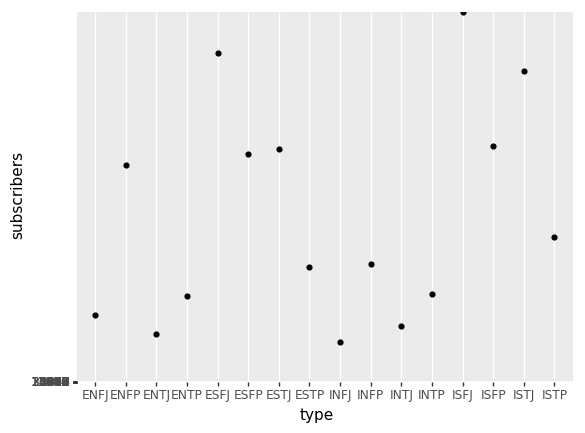

<ggplot: (-9223371846356880331)>

In [16]:
(ggplot(df.reset_index())
 + geom_col(aes('type', 'subscribers'))
 + geom_point(aes('type', y='subscribers_expected'))
#  + geom_path(aes('type', y='subscribers_expected'))
#  + ggtitle('Subreddit Subscribers by MBTI Personality Type')
)

In [25]:
df.sort_values(['subscribers'])

,display_name,created_utc,description,name,subscribers,gilded,pop_freq,description_length,creation_date,subreddit_age,subscribers_percentage,pt_percentage_differences,type
ESFJ,ESFJ,1.33159e+09,">* [NT, Rationalists](http://www.reddit.com/r/...",t5_2tpru,872,0,0.123,658,2012-03-12 23:02:42,2000 days 15:32:34.804704,0.00511851,0.117881,ESFJ
ESTJ,ESTJ,1.32919e+09,ESTJ,t5_2tk2p,890,0,0.087,4,2012-02-14 04:23:18,2028 days 10:11:58.804704,0.00522417,0.0817758,ESTJ
ESFP,ESFP,1.35041e+09,"##Description\n\nThe MBTI, short for Myers-Bri...",t5_2vb68,945,0,0.085,1346,2012-10-16 18:29:05,1782 days 20:06:11.804704,0.00554701,0.079453,ESFP
ESTP,estp,1.33294e+09,"-----\n**ESTPs** are outgoing, straight-shooti...",t5_2tt3a,1075,0,0.043,925,2012-03-28 14:02:32,1985 days 00:32:44.804704,0.00631009,0.0366899,ESTP
ISFP,isfp,1.24863e+09,##What is ISFP and MBTI? \n\nThe Myers-Briggs ...,t5_2r39d,2516,0,0.088,1829,2009-07-26 18:23:17,2960 days 20:11:59.804704,0.0147686,0.0732314,ISFP
ISFJ,isfj,1.24863e+09,##Introverted Sensing Feeling Judging\n\n\n###...,t5_2r39e,3048,1,0.138,1133,2009-07-26 18:23:37,2960 days 20:11:39.804704,0.0178913,0.120109,ISFJ
ENFJ,enfj,1.24852e+09,**Quote of the Week/Month (Whenever mod rememb...,t5_2r36p,3592,0,0.025,1751,2009-07-25 09:58:20,2962 days 04:36:56.804704,0.0210845,0.00391549,ENFJ
ISTJ,ISTJ,1.2504e+09,**Introverted Sensing Thinking Judging**\n\nWe...,t5_2r4yh,4436,1,0.116,1962,2009-08-16 06:33:55,2940 days 08:01:21.804704,0.0260387,0.0899613,ISTJ
ENTJ,entj,1.24852e+09,The Myers-Briggs Type Indicator (MBTI) is a te...,t5_2r36o,4798,5,0.018,1818,2009-07-25 09:57:16,2962 days 04:38:00.804704,0.0281636,-0.0101636,ENTJ
ISTP,istp,1.24863e+09,##Introverted Sensing Thinking Perceiving\n-\n...,t5_2r39c,5144,9,0.054,2087,2009-07-26 18:21:33,2960 days 20:13:43.804704,0.0301945,0.0238055,ISTP


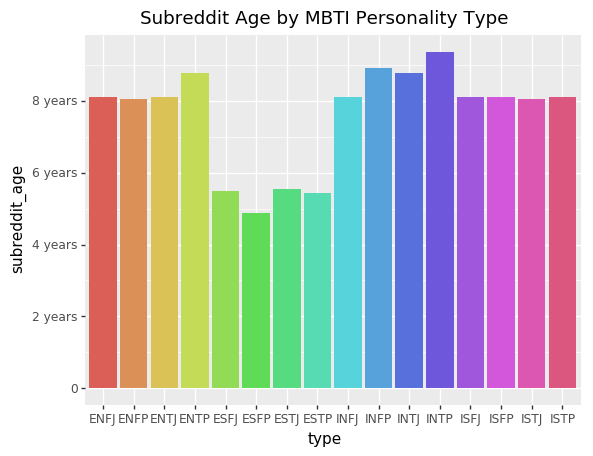

<ggplot: (-9223371908214979496)>

In [18]:
(ggplot(df) +
     aes(x='type', y='subreddit_age', fill='type') +
     geom_bar(stat="identity") +
     guides(fill=False) +
     ggtitle('Subreddit Age by MBTI Personality Type'))

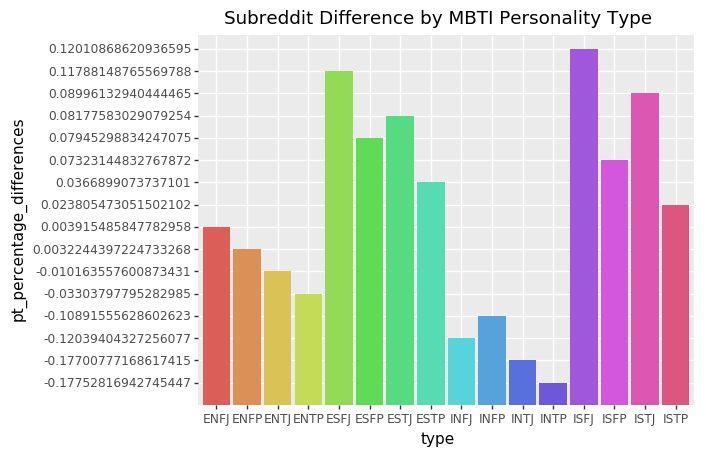

<ggplot: (128639984076)>

In [19]:
(ggplot(df) +
 aes(x='type', y='pt_percentage_differences', fill='type') +
 geom_bar(stat="identity") +
 guides(fill=False) +
 ggtitle('Subreddit Difference by MBTI Personality Type'))

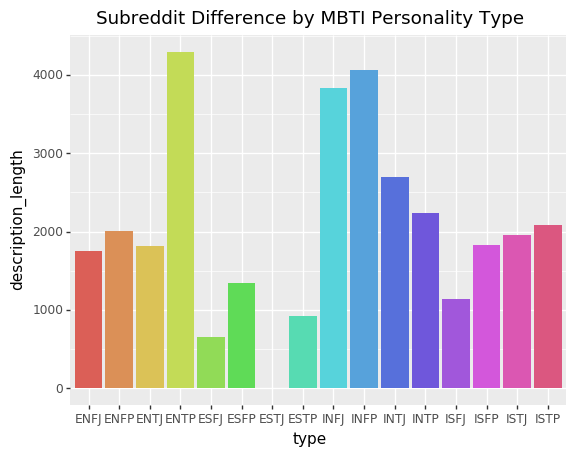

<ggplot: (-9223371908215031075)>

In [75]:
(ggplot(df) +
 aes(x='type', y='description_length', fill='type') +
 geom_bar(stat="identity") +
 guides(fill=False) +
 ggtitle('Subreddit Difference by MBTI Personality Type'))